<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         9997 non-null   float64
 1   year          9997 non-null   float64
 2   manufacturer  9997 non-null   object 
 3   condition     9997 non-null   object 
 4   cylinders     9997 non-null   object 
 5   fuel          9997 non-null   object 
 6   odometer      9331 non-null   float64
 7   transmission  9997 non-null   object 
 8   type          9997 non-null   object 
 9   paint_color   9997 non-null   object 
 10  F1            9997 non-null   int64  
 11  F2            9997 non-null   float64
 12  F3            9997 non-null   float64
 13  F4            9997 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.1+ MB


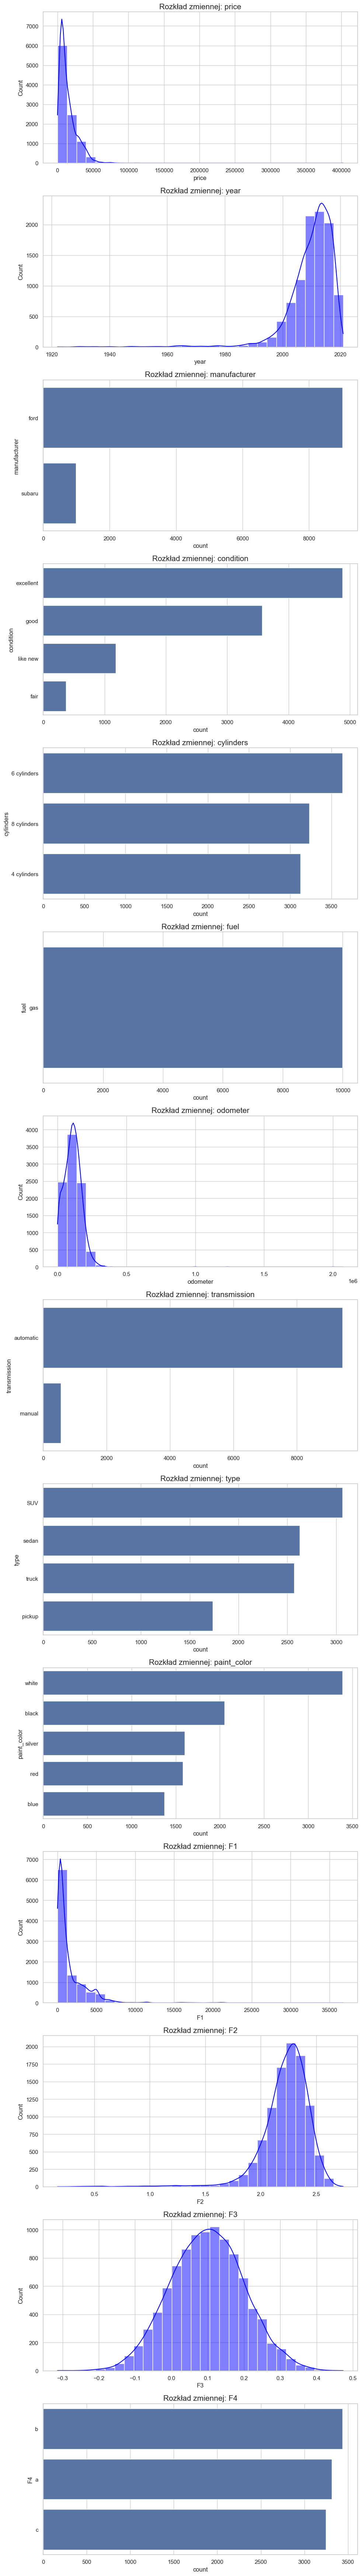

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Dane treningowe
df = pd.read_csv('./data/used_car_dataset.csv')

df.head()
df.info()
df.describe()
df.isnull().sum()

# Stworzenie wykresów dla każdej kolumny
fig, axes = plt.subplots(nrows=len(df.columns), figsize=(10, 5*len(df.columns)))

for ax, column in zip(axes, df.columns):
    if df[column].dtype == 'object':
        sns.countplot(y=column, data=df, order=df[column].value_counts().index, ax=ax)
        ax.set_title(f'Rozkład zmiennej: {column}', fontsize=15)
    else:
        sns.histplot(df[column], bins=30, kde=True, ax=ax, color="blue")
        ax.set_title(f'Rozkład zmiennej: {column}', fontsize=15)

plt.tight_layout()
plt.show()

Wyniki RMSE dla modeli: {'Linear': 12918.195955375082, 'Ridge': 12918.657120933882, 'Lasso': 12918.509076416698, 'ElasticNet': 13508.255483164328}
Najlepszy model: Linear
Ostateczny Test RMSE dla Linear: 9972.39


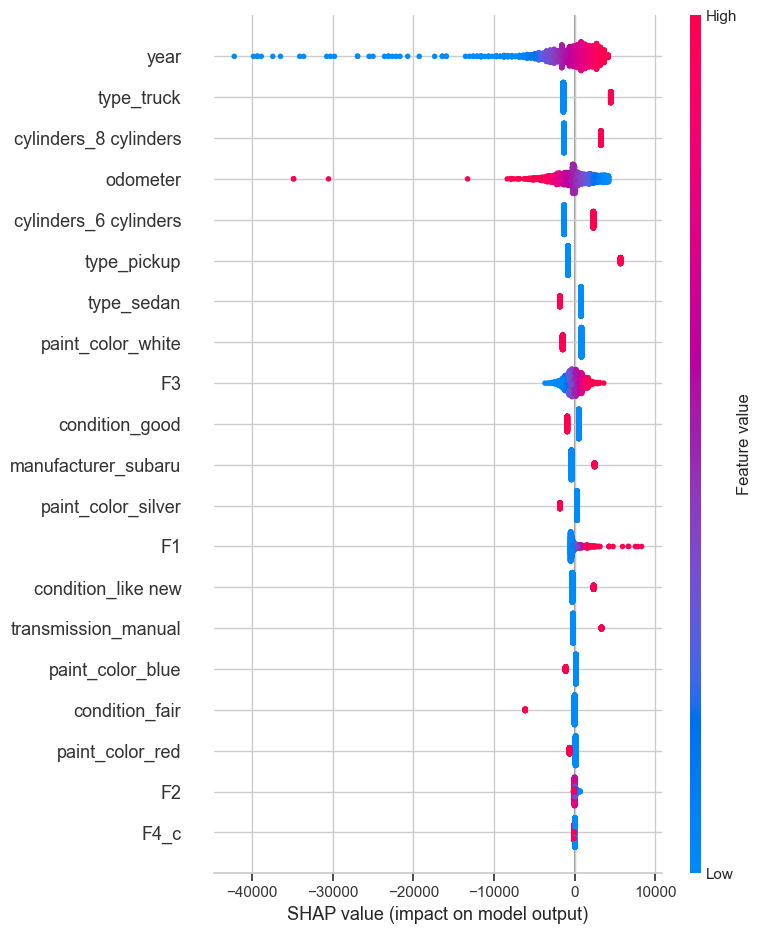

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import shap

# Podział danych
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Oddzielenie cech od targetu ('price')
X_train = train_df.drop(columns=['price'])
y_train = train_df['price']

X_valid = valid_df.drop(columns=['price'])
y_valid = valid_df['price']

X_test = test_df.drop(columns=['price'])
y_test = test_df['price']


# Kodowanie zmiennych kategorycznych
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_valid_encoded = pd.get_dummies(X_valid, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Upewnienie się, że kolumny są takie same
X_valid_encoded = X_valid_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Imputacja brakujących wartości
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train_encoded)
X_valid_imputed = imputer.transform(X_valid_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

results = {}

# Trening modeli i wybór najlepszego
for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_valid_imputed)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    results[name] = rmse

# Wyświetlenie wyników
print("Wyniki RMSE dla modeli:", results)

# Wybór najlepszego modelu
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
print(f"Najlepszy model: {best_model_name}")

# Predykcja na zbiorze testowym
y_test_pred = best_model.predict(X_test_imputed)

# Obliczenie RMSE na zbiorze testowym
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Ostateczny Test RMSE dla {best_model_name}: {test_rmse:.2f}")

# SHAP wymaga DataFrame z nazwami kolumn
X_test_df = pd.DataFrame(X_test_imputed, columns=X_train_encoded.columns)
X_train_df = pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)

explainer = shap.Explainer(best_model, X_train_df)
shap_values = explainer(X_test_df)

# Wizualizacja wyników SHAP
shap.summary_plot(shap_values, features=X_test_df)

## Podsumowanie dla CEO

Na podstawie analizy danych o cenach używanych samochodów i zastosowaniu modelu regresji Ridge, wykryto następujące kluczowe czynniki wpływające na cenę:

- Rok produkcji (year)

        Największy wpływ na cenę samochodu ma jego rocznik. Samochody nowsze mają istotnie wyższą wartość. Każdy dodatkowy rok zwiększa cenę pojazdu średnio o kilka tysięcy dolarów.

- Typ pojazdu (type)

        Rodzaj pojazdu znacząco wpływa na cenę. Samochody typu „truck” oraz „pickup” zwykle osiągają wyższe ceny, natomiast sedany mają wartość nieco niższą.

- Liczba cylindrów (cylinders)

        Pojazdy z większą liczbą cylindrów (zwłaszcza 8-cylindrowe) są droższe niż te o mniejszych silnikach.

- Przebieg (odometer)

        Wyższy przebieg istotnie obniża wartość samochodu. Im większy przebieg, tym wyraźnie niższa cena sprzedaży.

- Kolor auta (paint_color)

        Samochody w kolorze białym i srebrnym są nieco droższe od samochodów w innych kolorach (np. czerwonych lub niebieskich).

- Stan techniczny (condition)

        Stan „like new” lub „good” podwyższa cenę, podczas gdy stan „fair” zdecydowanie ją obniża.

Wpływ specjalnych modyfikacji (F1–F4):
- Modyfikacje (oznaczone w danych jako F1, F2, F3, F4) mają znacznie mniejszy, choć zauważalny wpływ na cenę. Szczególnie F3 wydaje się mieć nieco większy pozytywny wpływ na wartość końcową niż inne modyfikacje.

### Rekomendacja:
Na podstawie analizy, warto inwestować w nowsze samochody, o mniejszym przebiegu, najlepiej typu truck lub pickup, w dobrym lub bardzo dobrym stanie technicznym. Kolory biały lub srebrny mogą również wpłynąć na szybszą i bardziej korzystną sprzedaż. Spośród modyfikacji szczególnie rekomendowana jest modyfikacja F3, ponieważ najbardziej korzystnie wpływa na ostateczną cenę.

## Podsumowanie dla Technical Manager
1. Wstęp

    W celu przewidywania cen samochodów używanych przygotowano model predykcyjny w oparciu o następujące modele liniowe:
    - Linear Regression
    - Ridge Regression
    - Lasso Regression
    - Elastic Net Regression

    Do treningu użyto zbioru danych podzielonego na trzy części:

    - treningowy (70%)
    - walidacyjny (15%)
    - testowy (15%)


2. Przygotowanie danych
    - Dane kategoryczne przetworzono metodą One-Hot Encoding.
    - Brakujące wartości uzupełniono średnią wartością kolumny (imputacja).
3. Wybór najlepszego modelu
    Na podstawie błędu RMSE uzyskanego na zbiorze walidacyjnym, dokonano porównania modeli. Wyniki przedstawiają się następująco:

    - Linear Regression: RMSE = 12918.20
    - Ridge Regression: RMSE = 12918.66
    - Lasso Regression: RMSE = 12918.51
    - Elastic Net Regression: RMSE = 13508.26

    Najlepszy wynik uzyskano dla modelu Linear Regression.
4. Ocena najlepszego modelu
    - Model ostatecznie oceniono na danych testowych.

    - Wynik RMSE dla najlepszego modelu (Linear): 9972.39
5. Interpretacja wyników SHAP
    Dla oceny istotności zmiennych zastosowano technikę SHAP (SHapley Additive exPlanations):

    Na podstawie analizy SHAP wyróżniono czynniki o największym wpływie na cenę samochodu:

    - Rok produkcji - istotny pozytywny wpływ.

    - Typ pojazdu (np. truck) - duży wpływ na wzrost ceny.

    - Przebieg (odometer) - wysoki przebieg istotnie obniża cenę.

    - Liczba cylindrów - większa liczba cylindrów zwiększa cenę.

    Modyfikacje specjalne F1–F4 mają umiarkowany wpływ, z modyfikacją F3 jako najbardziej istotną w zwiększaniu wartości pojazdu.